<a href="https://colab.research.google.com/github/GreyPaldin/CV_LB2/blob/main/LB2_VIZHEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python opencv-python-headless
!git clone https://github.com/GreyPaldin/CV_LB2.git
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from google.colab import drive
from google.colab.patches import cv2_imshow
image_one = '/content/CV_LB2/one.jpg'
image_two = '/content/CV_LB2/two.jpg'
image_two2 = '/content/CV_LB2/two2.jpg'
image_generate = '/content/CV_LB2/generate.jpg'
image_one_left_X = '/content/CV_LB2/one_correct_X_left.jpg'
image_one_UP_y = '/content/CV_LB2/Up_Y.jpg'
image_one_rot = '/content/CV_LB2/one _поворот.jpg'
img_one = cv2.imread(image_one)
img_two = cv2.imread(image_two)
img_generate = cv2.imread(image_generate)
img_one_UP_y = cv2.imread(image_one_UP_y)
img_one_rot = cv2.imread(image_one_rot)


Cloning into 'CV_LB2'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 202 (delta 76), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (202/202), 9.26 MiB | 13.61 MiB/s, done.
Resolving deltas: 100% (76/76), done.


Задача стостоит загрузить две картинки, одна из которых имеет смещение относительно другой. Это могут быть искуственносозданные ситуации.

Итак, надо будет сделать следующий пул задач:


1.   Выбрать алгоритм поиска опорных точек
2.   Фильтрация опорных точек
3.   Сопастовление опорных точеки на двух ихображений
4.   Сделать выводы

Задача сводится к нахождению опорных точек и сопастовлению.



In [ ]:
#@title Модель с сервисной информацией
import numpy as np
from scipy.ndimage import label, gaussian_filter
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment  # Венгерский алгоритм
import cv2  # Импортируем OpenCV


def extract_blob_features(image, blob, blobs, k_neighbors=3):
    """Извлекает признаки из блоба, включая относительное расположение."""
    x, y, area = blob
    # Ограничиваем область, чтобы не вылезать за границы картинки
    x_start = int(x - np.sqrt(area / np.pi))
    x_end = int(x + np.sqrt(area / np.pi))
    y_start = int(y - np.sqrt(area / np.pi))
    y_end = int(y + np.sqrt(area / np.pi))

    blob_image = image[max(0, y_start):min(image.shape[0], y_end), max(0, x_start):min(image.shape[1], x_end)] #Обрезаем изображение

    # Вычисляем среднюю интенсивность
    mean_intensity = np.mean(blob_image)

    # Вычисляем LBP (пример)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(blob_image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Нормализация

    # Находим k ближайших соседей
    distances = []
    neighbors = []

    for other_blob in blobs:
        if other_blob is not blob:
            x2, y2, _ = other_blob
            distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
            distances.append(distance)

    # Находим индексы k ближайших соседей
    neighbor_indices = np.argsort(distances)[:k_neighbors]  # Сортировка и берем только k

    # Преобразуем индексы соседей в блобы
    for idx in neighbor_indices:
        neighbors.append(blobs[idx])

    # Вычисляем относительные расстояния (нормализация по размеру изображения)
    relative_distances = []
    for neighbor in neighbors:
        x2, y2, _ = neighbor
        distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
        relative_distance = distance / max(image.shape[0], image.shape[1], 1)  # Нормализация
        relative_distances.append(relative_distance)

    # Заполняем нулями, если у блоба меньше k соседей
    while len(relative_distances) < k_neighbors:
        relative_distances.append(0.0)  # Добавляем нули

    # Вычисляем относительные углы
    relative_angles = []
    for neighbor in neighbors:
        x2, y2, _ = neighbor
        dx = x2 - x
        dy = y2 - y
        angle = np.arctan2(dy, dx)  # Угол в радианах
        relative_angle = angle / (2 * np.pi)  # Нормализация
        relative_angles.append(relative_angle)

    while len(relative_angles) < k_neighbors:
        relative_angles.append(0.0)  # Добавляем нули

    return area, mean_intensity, hist, relative_distances, relative_angles


def compare_features(feature1, feature2, k_neighbors=3):
    """Сравнивает два набора признаков, учитывая относительное расположение."""
    area1, mean_intensity1, hist1, relative_distances1, relative_angles1 = feature1
    area2, mean_intensity2, hist2, relative_distances2, relative_angles2 = feature2

    # Вычисляем разницу признаков (нормализуем)
    area_diff = abs(area1 - area2) / max(area1, area2, 1)
    intensity_diff = abs(mean_intensity1 - mean_intensity2) / max(mean_intensity1, mean_intensity2, 1)
    hist_diff = np.sum(((hist1 - hist2) ** 2) / (hist1 + hist2 + 1e-7))  # avoid division by zero
    #  Вычисляем разницу по относительным расстояниям (L1-distance)
    relative_distance_diff = np.sum(np.abs(np.array(relative_distances1) - np.array(relative_distances2))) / k_neighbors  # L1, normalised by k
    relative_angle_diff = np.sum(np.abs(np.array(relative_angles1) - np.array(relative_angles2))) / k_neighbors

    #  Объединяем различия, увеличивая вес относительного расположения
    similarity = (
        0.4 * (1 - area_diff)
        + 0.2 * (1 - intensity_diff)
        + 0.2 * (1 - np.mean(hist_diff))
        + 0.1 * (1 - relative_distance_diff)  # Добавлено относительное расстояние
        + 0.1 * (1 - relative_angle_diff)  # Добавлен относительный угол
    )

    return similarity


def match_blobs(blobs1, blobs2, image1, image2, threshold=0.8):  # Изменили порог
    """Сопоставляет блобы между двумя изображениями, используя Венгерский алгоритм."""
    # Проверяем, что изображения не None
    if image1 is None or image2 is None:
        print("Ошибка: Одно или оба изображения не загружены.")
        return [], [], []  # Возвращаем пустые списки

    features1 = [extract_blob_features(image1, blob, blobs1) for blob in blobs1]
    features2 = [extract_blob_features(image2, blob, blobs2) for blob in blobs2]

    # Создаем матрицу СХОДСТВА (а не стоимости)
    similarity_matrix = np.zeros((len(blobs1), len(blobs2)))
    for i, blob1 in enumerate(blobs1):
        for j, blob2 in enumerate(blobs2):
            similarity_matrix[i, j] = compare_features(features1[i], features2[j])

    # Инвертируем матрицу, чтобы использовать Венгерский алгоритм (он ищет минимум)
    cost_matrix = 1 - similarity_matrix

    # Используем Венгерский алгоритм для нахождения оптимального сопоставления
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Отфильтровываем сопоставления с ПОРОГОМ СХОДСТВА
    matches = []
    unmatched1 = list(range(len(blobs1)))  # Изначально все блобы не сопоставлены
    unmatched2 = list(range(len(blobs2)))
    for i, j in zip(row_ind, col_ind):
        if similarity_matrix[i, j] > threshold:  # Изменили знак сравнения
            matches.append((i, j))  # (индекс блоба в blobs1, индекс блоба в blobs2)
            if i in unmatched1:
                unmatched1.remove(i)  # Удаляем из списка несопоставленных, так как сопоставление найдено
            if j in unmatched2:
                unmatched2.remove(j)  # Удаляем из списка несопоставленных
        else:
            print(
                f"Отфильтровано сопоставление {i} <-> {j} с похожестью {similarity_matrix[i, j]:.2f} из-за порога {threshold}"
            )  # Для отладки

    return matches, unmatched1, unmatched2  # Возвращаем индексы несопоставленных блобов


def visualize_matches(
    image1, blobs1, image2, blobs2, matches, title="Сопоставленные блобы"
):
    """Отображает изображения с сопоставленными блобами."""
    num_matches = len(matches)

    # Main Images with annotations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image1, cmap='gray')
    ax1.set_title("Image 1")
    ax2.imshow(image2, cmap='gray')
    ax2.set_title("Image 2")

    # Create sorted list for correct numeration on the image
    sorted_blobs1 = [None] * num_matches
    sorted_blobs2 = [None] * num_matches

    # Create matches for the new indexes
    new_matches = []
    for k, (i, j) in enumerate(matches):
        sorted_blobs1[k] = blobs1[i]
        sorted_blobs2[k] = blobs2[j]
        new_matches.append((k, k))  # New matches are (0,0), (1,1), etc. on the new lists

    # Annotate blob matches. We iterate with *new* indexes.
    for k, blob in enumerate(sorted_blobs1):
        if blob is not None:  # just in case
            x, y, area = blob
            circle = plt.Circle((x, y), radius=np.sqrt(area / np.pi), color='r', fill=False)
            ax1.add_patch(circle)
            ax1.text(x, y, str(k + 1), color='white', ha='center', va='center') # number k+1

    for k, blob in enumerate(sorted_blobs2):
        if blob is not None:  # just in case
            x, y, area = blob
            circle = plt.Circle((x, y), radius=np.sqrt(area / np.pi), color='g', fill=False)
            ax2.add_patch(circle)
            ax2.text(x, y, str(k + 1), color='white', ha='center', va='center')  # number k+1

    plt.suptitle(title)
    plt.show()

    #  Display Cropped Images on a Separate Figure
    for k, (i, j) in enumerate(matches):
      #New images with cropped images
        fig, axes = plt.subplots(1, 2, figsize=(4, 2))

        # Extract image parts, etc.
        x1, y1, area1 = blobs1[i]
        x2, y2, area2 = blobs2[j]

        size1 = int(2 * np.sqrt(area1 / np.pi)) #Circle diameter
        size2 = int(2 * np.sqrt(area2 / np.pi))

        crop1 = crop_blob(image1, x1, y1, size1)
        crop2 = crop_blob(image2, x2, y2, size2)

        # Display cropped
        axes[0].imshow(crop1, cmap='gray')
        axes[0].set_title(f"Blob {k + 1} (Image 1)")  # index now k+1
        axes[1].imshow(crop2, cmap='gray')
        axes[1].set_title(f"Blob {k + 1} (Image 2)")  # index now k+1

        plt.tight_layout()  # Automate place for plots
        plt.show()  # Create a *separate* picture with each cut



def crop_blob(image, x, y, size):
    """Вырезает квадратный фрагмент изображения вокруг блоба."""
    x_start = int(x - size / 2)
    x_end = int(x + size / 2)
    y_start = int(y - size / 2)
    y_end = int(y + size / 2)

    # Обрезаем и обрабатываем граничные случаи
    x_start = max(0, x_start)
    y_start = max(y_start, 0)  # Исправлено
    x_end = min(x_end, image.shape[1])  # Исправлено
    y_end = min(y_end, image.shape[0])  # Исправлено

    return image[y_start:y_end, x_start:x_end]


def detect_blobs(image, threshold, min_area):
    """
    Обнаруживает блобы в изображении на основе пороговой обработки и площади.

    Args:
        image (numpy.ndarray): Изображение в оттенках серого (2D numpy array).
        threshold (int): Порог для бинаризации изображения.
        min_area (int): Минимальная площадь блоба (в пикселях).

    Returns:
        list: Список кортежей, представляющих блобы. Каждый кортеж содержит
              (центр_x, центр_y, площадь).
    """
    # Проверяем, что изображение не равно None
    if image is None:
        print("Ошибка: Изображение равно None. Убедитесь, что оно успешно загружено.")
        return []  # Возвращаем пустой список, чтобы избежать дальнейших ошибок

    # 1. Пороговая обработка (бинаризация)
    binary_image = image > threshold
    plt.imshow(binary_image, cmap='gray') #Отображаем в серых тонах (чёрный - фон, белый - блобы)
    plt.title("Бинаризованное изображение")
    plt.show()

    # 2. Связный анализ компонентов
    labeled_image = label(binary_image)
    num_labels = labeled_image[1]

    plt.figure(figsize=(8, 6)) #Устанавливаем размер графика
    plt.imshow(labeled_image[0], cmap=plt.cm.nipy_spectral)  # Используем colormap
    plt.title("Labeled Image (Colored)")
    plt.colorbar(label="Blob ID")  # Добавляем шкалу цветов
    plt.show()

    print("Список блобов:")
    for i in range(1, num_labels + 1): #Перебираем от 1 до num_labels включительно
        area = np.sum(labeled_image[0] == i) #Подсчитываем количество пикселей в каждом блобе
        print(f"Блоб {i}: {area} пикселей")

    # 3. Извлечение свойств блобов
    blobs = []
    for i in range(1, num_labels):  # Начинаем с 1 (0 - фон)
        blob_pixels = np.where(labeled_image[0] == i)
        y_coords = blob_pixels[0]
        x_coords = blob_pixels[1]

        area = len(y_coords)

        # Фильтрация по площади
        if area >= min_area:
            # Вычисление центра масс (центроида)
            center_x = np.mean(x_coords)
            center_y = np.mean(y_coords)

            blobs.append((center_x, center_y, area))

    return blobs


# 1. Загрузка изображений (или создание тестовых изображений)
image1_path = '/content/CV_LB2/one.jpg'
image2_path = '/content/CV_LB2/generate.jpg'


img_one = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)  # Загружаем в оттенках серого
img_two = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)  # Загружаем в оттенках серого

# Применяем размытие (уменьшаем шум)
if img_one is not None:
    img_one = gaussian_filter(img_one, sigma=1)
if img_two is not None:
    img_two = gaussian_filter(img_two, sigma=1)


# Проверка успешности загрузки и размерности
if img_one is None:
    print(f"Ошибка: Не удалось загрузить изображение {image1_path}")
elif img_one.ndim != 2:
    print(f"Ошибка: Изображение {image1_path} не является изображением в оттенках серого (размерность != 2)")
else:
    print(f"Изображение {image1_path} загружено успешно, размерность: {img_one.shape}")

if img_two is None:
    print(f"Ошибка: Не удалось загрузить изображение {image2_path}")
elif img_two.ndim != 2:
    print(f"Ошибка: Изображение {image2_path} не является изображением в оттенках серого (размерность != 2)")
else:
    print(f"Изображение {image2_path} загружено успешно, размерность: {img_two.shape}")


# 2. Параметры (одинаковые для обоих изображений, но можно настраивать отдельно)
threshold = 150
min_area = 250
k_neighbors = 3  # Количество ближайших соседей для учета расположения

# 3. Обнаружение блобов в первом изображении
blobs1 = []
blobs2 = []

#Обнаружение блобов только если изображения загружены успешно
if img_one is not None:
  blobs1 = detect_blobs(img_one, threshold, min_area)
if img_two is not None:
  blobs2 = detect_blobs(img_two, threshold, min_area)

# 4. Извлечение признаков, учитывая относительное расположение
features1 = [extract_blob_features(img_one, blob, blobs1, k_neighbors) for blob in blobs1]
features2 = [extract_blob_features(img_two, blob, blobs2, k_neighbors) for blob in blobs2]

# 5. Сопоставление блобов
matches, unmatched1, unmatched2 = [],[],[]
if img_one is not None and img_two is not None:
    matches, unmatched1, unmatched2 = match_blobs(blobs1, blobs2, img_one, img_two, threshold=0.94)  # Настраиваем порог СХОДСТВА

# Визуализация результатов
if img_one is not None and img_two is not None:
    visualize_matches(img_one, blobs1, img_two, blobs2, matches, title="Сопоставление блобов")

# Вывод количества результатов
print(f"Найдено {len(blobs1)} блобов в первом изображении.")
print(f"Найдено {len(blobs2)} блобов во втором изображении.")
print(f"Найдено {len(matches)} соответствий.")
print(f"Не сопоставлено {len(unmatched1)} блобов на первом изображении.") # Вывод числа несопоставленных блобов
print(f"Не сопоставлено {len(unmatched2)} блобов на втором изображении.") # Вывод числа несопоставленных блобов




In [ ]:
#@title Модель для сравнения перемещений для одной пары изображений
import numpy as np
from scipy.ndimage import label, gaussian_filter, rotate
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment  # Венгерский алгоритм
import cv2  # Импортируем OpenCV
import math


def extract_blob_features(image, blob, blobs, k_neighbors=3):
    """Извлекает признаки из блоба, включая относительное расположение."""
    x, y, area = blob
    # Ограничиваем область, чтобы не вылезать за границы картинки
    x_start = int(x - np.sqrt(area / np.pi))
    x_end = int(x + np.sqrt(area / np.pi))
    y_start = int(y - np.sqrt(area / np.pi))
    y_end = int(y + np.sqrt(area / np.pi))

    blob_image = image[max(0, y_start):min(image.shape[0], y_end), max(0, x_start):min(image.shape[1], x_end)] #Обрезаем изображение

    # Вычисляем среднюю интенсивность
    mean_intensity = np.mean(blob_image)

    # Вычисляем LBP (пример)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(blob_image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Нормализация

    # Находим k ближайших соседей
    distances = []
    neighbors = []

    for other_blob in blobs:
        if other_blob is not blob:
            x2, y2, _ = other_blob
            distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
            distances.append(distance)

    # Находим индексы k ближайших соседей
    neighbor_indices = np.argsort(distances)[:k_neighbors]  # Сортировка и берем только k

    # Преобразуем индексы соседей в блобы
    for idx in neighbor_indices:
        neighbors.append(blobs[idx])

    # Вычисляем относительные расстояния (нормализация по размеру изображения)
    relative_distances = []
    for neighbor in neighbors:
        x2, y2, _ = neighbor
        distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
        relative_distance = distance / max(image.shape[0], image.shape[1], 1)  # Нормализация
        relative_distances.append(relative_distance)

    # Заполняем нулями, если у блоба меньше k соседей
    while len(relative_distances) < k_neighbors:
        relative_distances.append(0.0)  # Добавляем нули

    # Вычисляем относительные углы
    relative_angles = []
    for neighbor in neighbors:
        x2, y2, _ = neighbor
        dx = x2 - x
        dy = y2 - y
        angle = np.arctan2(dy, dx)  # Угол в радианах
        relative_angle = angle / (2 * np.pi)  # Нормализация
        relative_angles.append(relative_angle)

    while len(relative_angles) < k_neighbors:
        relative_angles.append(0.0)  # Добавляем нули

    return area, mean_intensity, hist, relative_distances, relative_angles


def compare_features(feature1, feature2, k_neighbors=3):
    """Сравнивает два набора признаков, учитывая относительное расположение."""
    area1, mean_intensity1, hist1, relative_distances1, relative_angles1 = feature1
    area2, mean_intensity2, hist2, relative_distances2, relative_angles2 = feature2

    # Вычисляем разницу признаков (нормализуем)
    area_diff = abs(area1 - area2) / max(area1, area2, 1)
    intensity_diff = abs(mean_intensity1 - mean_intensity2) / max(mean_intensity1, mean_intensity2, 1)
    hist_diff = np.sum(((hist1 - hist2) ** 2) / (hist1 + hist2 + 1e-7))  # avoid division by zero
    #  Вычисляем разницу по относительным расстояниям (L1-distance)
    relative_distance_diff = np.sum(np.abs(np.array(relative_distances1) - np.array(relative_distances2))) / k_neighbors  # L1, normalised by k
    relative_angle_diff = np.sum(np.abs(np.array(relative_angles1) - np.array(relative_angles2))) / k_neighbors

    #  Объединяем различия, увеличивая вес относительного расположения
    similarity = (
        0.40 * (1 - area_diff)
        + 0.30 * (1 - intensity_diff)
        + 0.10 * (1 - np.mean(hist_diff))
        + 0.10 * (1 - relative_distance_diff)  # Добавлено относительное расстояние
        + 0.10 * (1 - relative_angle_diff)  # Добавлен относительный угол
    )

    return similarity


def match_blobs(blobs1, blobs2, image1, image2, threshold=0.8):  # Изменили порог
    """Сопоставляет блобы между двумя изображениями, используя Венгерский алгоритм."""
    # Проверяем, что изображения не None
    if image1 is None or image2 is None:
        print("Ошибка: Одно или оба изображения не загружены.")
        return [], [], []  # Возвращаем пустые списки

    features1 = [extract_blob_features(image1, blob, blobs1) for blob in blobs1]
    features2 = [extract_blob_features(image2, blob, blobs2) for blob in blobs2]

    # Создаем матрицу СХОДСТВА (а не стоимости)
    similarity_matrix = np.zeros((len(blobs1), len(blobs2)))
    for i, blob1 in enumerate(blobs1):
        for j, blob2 in enumerate(blobs2):
            similarity_matrix[i, j] = compare_features(features1[i], features2[j])

    # Инвертируем матрицу, чтобы использовать Венгерский алгоритм (он ищет минимум)
    cost_matrix = 1 - similarity_matrix

    # Используем Венгерский алгоритм для нахождения оптимального сопоставления
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Отфильтровываем сопоставления с ПОРОГОМ СХОДСТВА
    matches = []
    unmatched1 = list(range(len(blobs1)))  # Изначально все блобы не сопоставлены
    unmatched2 = list(range(len(blobs2)))
    for i, j in zip(row_ind, col_ind):
        if similarity_matrix[i, j] > threshold:  # Изменили знак сравнения
            matches.append((i, j))  # (индекс блоба в blobs1, индекс блоба в blobs2)
            if i in unmatched1:
                unmatched1.remove(i)  # Удаляем из списка несопоставленных, так как сопоставление найдено
            if j in unmatched2:
                unmatched2.remove(j)  # Удаляем из списка несопоставленных
        else:
            print(
                f"Отфильтровано сопоставление {i} <-> {j} с похожестью {similarity_matrix[i, j]:.2f} из-за порога {threshold}"
            )  # Для отладки

    return matches, unmatched1, unmatched2  # Возвращаем индексы несопоставленных блобов


def visualize_matches(
    image1, blobs1, image2, blobs2, matches, title="Сопоставление блобов", shift=None, rotation=None
):
    """Отображает изображения с сопоставленными блобами."""
    num_matches = len(matches)

    # Main Images with annotations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image1, cmap='gray')
    ax1.set_title("Image 1")
    ax2.imshow(image2, cmap='gray')
    ax2.set_title("Image 2")

    # Create sorted list for correct numeration on the image
    sorted_blobs1 = [None] * num_matches
    sorted_blobs2 = [None] * num_matches

    # Create matches for the new indexes
    new_matches = []
    for k, (i, j) in enumerate(matches):
        sorted_blobs1[k] = blobs1[i]
        sorted_blobs2[k] = blobs2[j]
        new_matches.append((k, k))  # New matches are (0,0), (1,1), etc. on the new lists

    # Annotate blob matches. We iterate with *new* indexes.
    for k, blob in enumerate(sorted_blobs1):
        if blob is not None:  # just in case
            x, y, area = blob
            circle = plt.Circle((x, y), radius=np.sqrt(area / np.pi), color='r', fill=False)
            ax1.add_patch(circle)
            ax1.text(x, y, str(k + 1), color='white', ha='center', va='center') # number k+1

    for k, blob in enumerate(sorted_blobs2):
        if blob is not None:  # just in case
            x, y, area = blob
            circle = plt.Circle((x, y), radius=np.sqrt(area / np.pi), color='g', fill=False)
            ax2.add_patch(circle)
            ax2.text(x, y, str(k + 1), color='white', ha='center', va='center')  # number k+1

    # Добавляем стрелку, показывающую смещение, если есть
    if shift:
        dx, dy = shift
        center_x = image1.shape[1] / 2  # Середина по горизонтали
        center_y = image1.shape[0] / 2  # Середина по вертикали
        ax1.arrow(center_x, center_y, dx, -dy, head_width=10, head_length=10, fc='blue', ec='blue')  # Инвертируем dy
        ax1.text(center_x + dx * 1.2, center_y - dy * 1.2, f"Смещение: dx={dx:.2f}, dy={dy:.2f}", color='blue')  # Инвертируем dy

    # Добавляем информацию о повороте, если есть
    if rotation:
        angle = rotation
        ax1.text(0.5, 0.1, f"Поворот: {angle:.2f} градусов", color='green', transform=ax1.transAxes, ha='center')

    plt.suptitle(title)
    plt.show()


    #  Display Cropped Images on a Separate Figure
    for k, (i, j) in enumerate(matches):
      #New images with cropped images
        fig, axes = plt.subplots(1, 2, figsize=(4, 2))

        # Extract image parts, etc.
        x1, y1, area1 = blobs1[i]
        x2, y2, area2 = blobs2[j]

        size1 = int(2 * np.sqrt(area1 / np.pi)) #Circle diameter
        size2 = int(2 * np.sqrt(area2 / np.pi))

        crop1 = crop_blob(image1, x1, y1, size1)
        crop2 = crop_blob(image2, x2, y2, size2)

        # Display cropped
        axes[0].imshow(crop1, cmap='gray')
        axes[0].set_title(f"Blob {k + 1} (Image 1)")  # index now k+1
        axes[1].imshow(crop2, cmap='gray')
        axes[1].set_title(f"Blob {k + 1} (Image 2)")  # index now k+1

        plt.tight_layout()  # Automate place for plots
        plt.show()  # Create a *separate* picture with each cut



def crop_blob(image, x, y, size):
    """Вырезает квадратный фрагмент изображения вокруг блоба."""
    x_start = int(x - size / 2)
    x_end = int(x + size / 2)
    y_start = int(y - size / 2)
    y_end = int(y + size / 2)

    # Обрезаем и обрабатываем граничные случаи
    x_start = max(0, x_start)
    y_start = max(y_start, 0)  # Исправлено
    x_end = min(x_end, image.shape[1])  # Исправлено
    y_end = min(y_end, image.shape[0])  # Исправлено

    return image[y_start:y_end, x_start:x_end]


def detect_blobs(image, threshold, min_area):
    """
    Обнаруживает блобы в изображении на основе пороговой обработки и площади.

    Args:
        image (numpy.ndarray): Изображение в оттенках серого (2D numpy array).
        threshold (int): Порог для бинаризации изображения.
        min_area (int): Минимальная площадь блоба (в пикселях).

    Returns:
        list: Список кортежей, представляющих блобы. Каждый кортеж содержит
              (центр_x, центр_y, площадь).
    """
    # Проверяем, что изображение не равно None
    if image is None:
        print("Ошибка: Изображение равно None. Убедитесь, что оно успешно загружено.")
        return []  # Возвращаем пустой список, чтобы избежать дальнейших ошибок

    # 1. Пороговая обработка (бинаризация)
    binary_image = image > threshold

    # 2. Связный анализ компонентов
    labeled_image = label(binary_image)
    num_labels = labeled_image[1]

    # 3. Извлечение свойств блобов
    blobs = []
    for i in range(1, num_labels + 1):  # Начинаем с 1 (0 - фон)
        blob_pixels = np.where(labeled_image[0] == i)
        y_coords = blob_pixels[0]
        x_coords = blob_pixels[1]

        area = len(y_coords)

        # Фильтрация по площади
        if area >= min_area:
            # Вычисление центра масс (центроида)
            center_x = np.mean(x_coords)
            center_y = np.mean(y_coords)

            blobs.append((center_x, center_y, area))

    return blobs


def estimate_shift(matches, blobs1, blobs2, inlier_threshold=2.0):
    """Оценивает смещение между двумя изображениями, используя RANSAC."""
    if not matches:
        return None

    # Prepare data for RANSAC
    src_pts = np.float32([blobs1[i][:2] for i, _ in matches])
    dst_pts = np.float32([blobs2[j][:2] for _, j in matches])

    # RANSAC parameters
    max_iters = 1000
    best_inliers = []
    best_dx = 0
    best_dy = 0

    for _ in range(max_iters):
        # Randomly sample two matches
        sample = np.random.choice(len(matches), 2, replace=False)
        i1, j1 = matches[sample[0]]
        i2, j2 = matches[sample[1]]

        # Compute potential shift
        dx = (blobs1[i1][0] - blobs2[j1][0] + blobs1[i2][0] - blobs2[j2][0]) / 2 # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
        dy = (blobs1[i1][1] - blobs2[j1][1] + blobs1[i2][1] - blobs2[j2][1]) / 2 # <--- ИЗМЕНЕНИЕ ЗДЕСЬ

        # Find inliers
        inliers = []
        for k, (i, j) in enumerate(matches):
            x1, y1, _ = blobs1[i]
            x2, y2, _ = blobs2[j]
            error = np.sqrt((x2 - x1 + dx)**2 + (y2 - y1 + dy)**2) # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
            if error < inlier_threshold:
                inliers.append(k)

        # Update best model if necessary
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_dx = dx
            best_dy = dy

    # Refine the shift estimate using inliers
    if len(best_inliers) > 0:
        inlier_dxs = []
        inlier_dys = []
        for k in best_inliers:
            i, j = matches[k]
            inlier_dxs.append(blobs1[i][0] - blobs2[j][0])  # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
            inlier_dys.append(blobs1[i][1] - blobs2[j][1])  # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
        best_dx = np.mean(inlier_dxs)
        best_dy = np.mean(inlier_dys)
    else:
        return None  # No reliable shift found

    return best_dx, -best_dy


def estimate_rotation_matrix(matches, blobs1, blobs2):
    """Оценивает угол поворота с использованием матрицы аффинного преобразования."""
    if not matches or len(matches) < 3:
        return None

    # Подготовка данных для OpenCV
    src_pts = np.float32([blobs1[i][:2] for i, _ in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([blobs2[j][:2] for _, j in matches]).reshape(-1, 1, 2)

    # Вычисление матрицы аффинного преобразования
    retval, inliers = cv2.estimateAffine2D(src_pts, dst_pts)

    if retval is None:
        return None

    # Извлечение матрицы поворота (первые два столбца, первые две строки)
    M = retval

    # Извлечение угла поворота из матрицы
    angle = math.atan2(M[1, 0], M[0, 0])

    return math.degrees(angle)


def calculate_angle(point1, point2):
    """Вычисляет угол между линией, соединяющей две точки, и горизонтальной осью."""
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    return math.atan2(dy, dx)

def estimate_rotation_angles(matches, blobs1, blobs2):
  """Оценивает угол поворота на основе разности углов между парами блобов."""
  if not matches or len(matches) < 2:
    return None

  num_blobs1 = len(blobs1)

  angles1 = []
  for i in range(num_blobs1):
    for j in range(i + 1, num_blobs1):
      x1, y1, _ = blobs1[i]
      x2, y2, _ = blobs1[j]
      angles1.append(calculate_angle((x1, y1), (x2, y2)))

  num_blobs2 = len(blobs2)
  angles2 = []
  for i in range(num_blobs2):
    for j in range(i + 1, num_blobs2):
      x1, y1, _ = blobs2[i]
      x2, y2, _ = blobs2[j]
      angles2.append(calculate_angle((x1, y1), (x2, y2)))

  return angles1, angles2

def estimate_rotation(matches, blobs1, blobs2):
  """Оценивает угол поворота, сравнивая углы между парами блобов на двух изображениях."""
  if not matches or len(matches) < 2:
    return None

  # Get Angles1 and Angles2
  angles1, angles2 = estimate_rotation_angles(matches, blobs1, blobs2)

  # If no combinations are present, rotation could not be found.
  if not angles1 or not angles2:
    return None

  # Initialize the resulting angle list
  diff_angles = []

  # Iterate through matches to find corresponding blob id
  for i, j in matches:
    # Get pairs of angles on image1 related to the current blob id
    anglePairs1 = []

    for k, angle1 in enumerate(angles1):
      if i in [0, 1]: #TODO Check and replace 0,1 for correct ids, now the assumption is 0 and 1 ids present on angles
        anglePairs1.append(angle1)
    # Get pairs of angles on image2 related to the current blob id
    anglePairs2 = []
    for k, angle2 in enumerate(angles2):
      if j in [0, 1]:  # TODO Check and replace 0,1 for correct ids, now the assumption is 0 and 1 ids present on angles
        anglePairs2.append(angle2)

    # With related angle pairs available, find the deltas
    if anglePairs1 and anglePairs2:
      for anglePair1 in anglePairs1:
        for anglePair2 in anglePairs2:
          diff_angles.append(anglePair2 - anglePair1)

  # With angle diffrences available - find the mean value
  if diff_angles:
    angle = sum(diff_angles) / len(diff_angles)
  else:
    angle = 0

  return math.degrees(angle)


# 1. Загрузка изображений (или создание тестовых изображений)
image1_path = '/content/CV_LB2/one.jpg'
image2_path = image_one_UP_y

img_one = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)  # Загружаем в оттенках серого
img_two = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)  # Загружаем в оттенках серого

# Применяем размытие (уменьшаем шум)
if img_one is not None:
    img_one = gaussian_filter(img_one, sigma=1)
if img_two is not None:
    img_two = gaussian_filter(img_two, sigma=1)


# Проверка успешности загрузки и размерности
if img_one is None:
    print(f"Ошибка: Не удалось загрузить изображение {image1_path}")
elif img_one.ndim != 2:
    print(f"Ошибка: Изображение {image1_path} не является изображением в оттенках серого (размерность != 2)")
else:
    print(f"Изображение {image1_path} загружено успешно, размерность: {img_one.shape}")

if img_two is None:
    print(f"Ошибка: Не удалось загрузить изображение {image2_path}")
elif img_two.ndim != 2:
    print(f"Ошибка: Изображение {image2_path} не является изображением в оттенках серого (размерность != 2)")
else:
    print(f"Изображение {image2_path} загружено успешно, размерность: {img_two.shape}")


# 2. Параметры (одинаковые для обоих изображений, но можно настраивать отдельно)
threshold = 128
min_area = 310
k_neighbors = 3  # Количество ближайших соседей для учета расположения

# 3. Обнаружение блобов в первом изображении
blobs1 = []
blobs2 = []

#Обнаружение блобов только если изображения загружены успешно
if img_one is not None:
  blobs1 = detect_blobs(img_one, threshold, min_area)
if img_two is not None:
  blobs2 = detect_blobs(img_two, threshold, min_area)

# 4. Извлечение признаков, учитывая относительное расположение
features1 = [extract_blob_features(img_one, blob, blobs1, k_neighbors) for blob in blobs1]
features2 = [extract_blob_features(img_two, blob, blobs2, k_neighbors) for blob in blobs2]

# 5. Сопоставление блобов
matches, unmatched1, unmatched2 = [],[],[]
if img_one is not None and img_two is not None:
    matches, unmatched1, unmatched2 = match_blobs(blobs1, blobs2, img_one, img_two, threshold=0.94)  # Настраиваем порог СХОДСТВА

# 6. Оценка смещения
shift = estimate_shift(matches, blobs1, blobs2)

# 7. Оценка поворота
rotation = estimate_rotation(matches, blobs1, blobs2)

# 8. Визуализация результатов
if img_one is not None and img_two is not None:
    visualize_matches(img_one, blobs1, img_two, blobs2, matches, title="Сопоставление блобов", shift=shift, rotation=rotation)

# Вывод количества результатов
print(f"Найдено {len(blobs1)} блобов в первом изображении.")
print(f"Найдено {len(blobs2)} блобов во втором изображении.")
print(f"Найдено {len(matches)} соответствий.")
print(f"Не сопоставлено {len(unmatched1)} блобов на первом изображении.") # Вывод числа несопоставленных блобов
print(f"Не сопоставлено {len(unmatched2)} блобов на втором изображении.") # Вывод числа несопоставленных блобов

# Вывод информации о смещении и повороте
if shift:
    dx, dy = shift
    print(f"Оценка смещения: dx={dx:.2f}, dy={dy:.2f}")
else:
    print("Не удалось оценить смещение (недостаточно соответствий).")

if rotation:
    print(f"Оценка поворота: {rotation:.2f} градусов")
else:
    print("Не удалось оценить поворот (недостаточно соответствий).")

In [ ]:
#@title Модель для сравнения всех изображений (перемещений)
import numpy as np
from scipy.ndimage import label, gaussian_filter, rotate
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment  # Венгерский алгоритм
import cv2  # Импортируем OpenCV
import math


def extract_blob_features(image, blob, blobs, k_neighbors=3):
    """Извлекает признаки из блоба, включая относительное расположение."""
    x, y, area = blob
    # Ограничиваем область, чтобы не вылезать за границы картинки
    x_start = int(x - np.sqrt(area / np.pi))
    x_end = int(x + np.sqrt(area / np.pi))
    y_start = int(y - np.sqrt(area / np.pi))
    y_end = int(y + np.sqrt(area / np.pi))

    blob_image = image[max(0, y_start):min(image.shape[0], y_end), max(0, x_start):min(image.shape[1], x_end)] #Обрезаем изображение

    # Вычисляем среднюю интенсивность
    mean_intensity = np.mean(blob_image)

    # Вычисляем LBP (пример)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(blob_image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Нормализация

    # Находим k ближайших соседей
    distances = []
    neighbors = []

    for other_blob in blobs:
        if other_blob is not blob:
            x2, y2, _ = other_blob
            distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
            distances.append(distance)

    # Находим индексы k ближайших соседей
    neighbor_indices = np.argsort(distances)[:k_neighbors]  # Сортировка и берем только k

    # Преобразуем индексы соседей в блобы
    for idx in neighbor_indices:
        neighbors.append(blobs[idx])

    # Вычисляем относительные расстояния (нормализация по размеру изображения)
    relative_distances = []
    for neighbor in neighbors:
        x2, y2, _ = neighbor
        distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
        relative_distance = distance / max(image.shape[0], image.shape[1], 1)  # Нормализация
        relative_distances.append(relative_distance)

    # Заполняем нулями, если у блоба меньше k соседей
    while len(relative_distances) < k_neighbors:
        relative_distances.append(0.0)  # Добавляем нули

    # Вычисляем относительные углы
    relative_angles = []
    for neighbor in neighbors:
        x2, y2, _ = neighbor
        dx = x2 - x
        dy = y2 - y
        angle = np.arctan2(dy, dx)  # Угол в радианах
        relative_angle = angle / (2 * np.pi)  # Нормализация
        relative_angles.append(relative_angle)

    while len(relative_angles) < k_neighbors:
        relative_angles.append(0.0)  # Добавляем нули

    return area, mean_intensity, hist, relative_distances, relative_angles


def compare_features(feature1, feature2, k_neighbors=3):
    """Сравнивает два набора признаков, учитывая относительное расположение."""
    area1, mean_intensity1, hist1, relative_distances1, relative_angles1 = feature1
    area2, mean_intensity2, hist2, relative_distances2, relative_angles2 = feature2

    # Вычисляем разницу признаков (нормализуем)
    area_diff = abs(area1 - area2) / max(area1, area2, 1)
    intensity_diff = abs(mean_intensity1 - mean_intensity2) / max(mean_intensity1, mean_intensity2, 1)
    hist_diff = np.sum(((hist1 - hist2) ** 2) / (hist1 + hist2 + 1e-7))  # avoid division by zero
    #  Вычисляем разницу по относительным расстояниям (L1-distance)
    relative_distance_diff = np.sum(np.abs(np.array(relative_distances1) - np.array(relative_distances2))) / k_neighbors  # L1, normalised by k
    relative_angle_diff = np.sum(np.abs(np.array(relative_angles1) - np.array(relative_angles2))) / k_neighbors

    #  Объединяем различия, увеличивая вес относительного расположения
    similarity = (
        0.40 * (1 - area_diff)
        + 0.30 * (1 - intensity_diff)
        + 0.10 * (1 - np.mean(hist_diff))
        + 0.10 * (1 - relative_distance_diff)  # Добавлено относительное расстояние
        + 0.10 * (1 - relative_angle_diff)  # Добавлен относительный угол
    )

    return similarity


def match_blobs(blobs1, blobs2, image1, image2, threshold=0.8):  # Изменили порог
    """Сопоставляет блобы между двумя изображениями, используя Венгерский алгоритм."""
    # Проверяем, что изображения не None
    if image1 is None or image2 is None:
        print("Ошибка: Одно или оба изображения не загружены.")
        return [], [], []  # Возвращаем пустые списки

    features1 = [extract_blob_features(image1, blob, blobs1) for blob in blobs1]
    features2 = [extract_blob_features(image2, blob, blobs2) for blob in blobs2]

    # Создаем матрицу СХОДСТВА (а не стоимости)
    similarity_matrix = np.zeros((len(blobs1), len(blobs2)))
    for i, blob1 in enumerate(blobs1):
        for j, blob2 in enumerate(blobs2):
            similarity_matrix[i, j] = compare_features(features1[i], features2[j])

    # Инвертируем матрицу, чтобы использовать Венгерский алгоритм (он ищет минимум)
    cost_matrix = 1 - similarity_matrix

    # Используем Венгерский алгоритм для нахождения оптимального сопоставления
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Отфильтровываем сопоставления с ПОРОГОМ СХОДСТВА
    matches = []
    unmatched1 = list(range(len(blobs1)))  # Изначально все блобы не сопоставлены
    unmatched2 = list(range(len(blobs2)))
    for i, j in zip(row_ind, col_ind):
        if similarity_matrix[i, j] > threshold:  # Изменили знак сравнения
            matches.append((i, j))  # (индекс блоба в blobs1, индекс блоба в blobs2)
            if i in unmatched1:
                unmatched1.remove(i)  # Удаляем из списка несопоставленных, так как сопоставление найдено
            if j in unmatched2:
                unmatched2.remove(j)  # Удаляем из списка несопоставленных
        else:
            print(
                f"Отфильтровано сопоставление {i} <-> {j} с похожестью {similarity_matrix[i, j]:.2f} из-за порога {threshold}"
            )  # Для отладки

    return matches, unmatched1, unmatched2  # Возвращаем индексы несопоставленных блобов


def visualize_matches(
    image1, blobs1, image2, blobs2, matches, title="Сопоставление блобов", shift=None, rotation=None
):
    """Отображает изображения с сопоставленными блобами."""
    num_matches = len(matches)

    # Main Images with annotations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image1, cmap='gray')
    ax1.set_title("Image 1")
    ax2.imshow(image2, cmap='gray')
    ax2.set_title("Image 2")

    # Create sorted list for correct numeration on the image
    sorted_blobs1 = [None] * num_matches
    sorted_blobs2 = [None] * num_matches

    # Create matches for the new indexes
    new_matches = []
    for k, (i, j) in enumerate(matches):
        sorted_blobs1[k] = blobs1[i]
        sorted_blobs2[k] = blobs2[j]
        new_matches.append((k, k))  # New matches are (0,0), (1,1), etc. on the new lists

    # Annotate blob matches. We iterate with *new* indexes.
    for k, blob in enumerate(sorted_blobs1):
        if blob is not None:  # just in case
            x, y, area = blob
            circle = plt.Circle((x, y), radius=np.sqrt(area / np.pi), color='r', fill=False)
            ax1.add_patch(circle)
            ax1.text(x, y, str(k + 1), color='white', ha='center', va='center') # number k+1

    for k, blob in enumerate(sorted_blobs2):
        if blob is not None:  # just in case
            x, y, area = blob
            circle = plt.Circle((x, y), radius=np.sqrt(area / np.pi), color='g', fill=False)
            ax2.add_patch(circle)
            ax2.text(x, y, str(k + 1), color='white', ha='center', va='center')  # number k+1

    # Добавляем стрелку, показывающую смещение, если есть
    if shift:
        dx, dy = shift
        center_x = image1.shape[1] / 2  # Середина по горизонтали
        center_y = image1.shape[0] / 2  # Середина по вертикали
        ax1.arrow(center_x, center_y, dx, -dy, head_width=10, head_length=10, fc='blue', ec='blue')  # Инвертируем dy
        ax1.text(center_x + dx * 1.2, center_y - dy * 1.2, f"Смещение: dx={dx:.2f}, dy={dy:.2f}", color='blue')  # Инвертируем dy

    # Добавляем информацию о повороте, если есть
    if rotation:
        angle = rotation
        ax1.text(0.5, 0.1, f"Поворот: {angle:.2f} градусов", color='green', transform=ax1.transAxes, ha='center')

    plt.suptitle(title)
    plt.show()


    #  Display Cropped Images on a Separate Figure
    for k, (i, j) in enumerate(matches):
      #New images with cropped images
        fig, axes = plt.subplots(1, 2, figsize=(4, 2))

        # Extract image parts, etc.
        x1, y1, area1 = blobs1[i]
        x2, y2, area2 = blobs2[j]

        size1 = int(2 * np.sqrt(area1 / np.pi)) #Circle diameter
        size2 = int(2 * np.sqrt(area2 / np.pi))

        crop1 = crop_blob(image1, x1, y1, size1)
        crop2 = crop_blob(image2, x2, y2, size2)

        # Display cropped
        axes[0].imshow(crop1, cmap='gray')
        axes[0].set_title(f"Blob {k + 1} (Image 1)")  # index now k+1
        axes[1].imshow(crop2, cmap='gray')
        axes[1].set_title(f"Blob {k + 1} (Image 2)")  # index now k+1

        plt.tight_layout()  # Automate place for plots
        plt.show()  # Create a *separate* picture with each cut



def crop_blob(image, x, y, size):
    """Вырезает квадратный фрагмент изображения вокруг блоба."""
    x_start = int(x - size / 2)
    x_end = int(x + size / 2)
    y_start = int(y - size / 2)
    y_end = int(y + size / 2)

    # Обрезаем и обрабатываем граничные случаи
    x_start = max(0, x_start)
    y_start = max(y_start, 0)  # Исправлено
    x_end = min(x_end, image.shape[1])  # Исправлено
    y_end = min(y_end, image.shape[0])  # Исправлено

    return image[y_start:y_end, x_start:x_end]


def detect_blobs(image, threshold, min_area):
    """
    Обнаруживает блобы в изображении на основе пороговой обработки и площади.

    Args:
        image (numpy.ndarray): Изображение в оттенках серого (2D numpy array).
        threshold (int): Порог для бинаризации изображения.
        min_area (int): Минимальная площадь блоба (в пикселях).

    Returns:
        list: Список кортежей, представляющих блобы. Каждый кортеж содержит
              (центр_x, центр_y, площадь).
    """
    # Проверяем, что изображение не равно None
    if image is None:
        print("Ошибка: Изображение равно None. Убедитесь, что оно успешно загружено.")
        return []  # Возвращаем пустой список, чтобы избежать дальнейших ошибок

    # 1. Пороговая обработка (бинаризация)
    binary_image = image > threshold

    # 2. Связный анализ компонентов
    labeled_image = label(binary_image)
    num_labels = labeled_image[1]

    # 3. Извлечение свойств блобов
    blobs = []
    for i in range(1, num_labels + 1):  # Начинаем с 1 (0 - фон)
        blob_pixels = np.where(labeled_image[0] == i)
        y_coords = blob_pixels[0]
        x_coords = blob_pixels[1]

        area = len(y_coords)

        # Фильтрация по площади
        if area >= min_area:
            # Вычисление центра масс (центроида)
            center_x = np.mean(x_coords)
            center_y = np.mean(y_coords)

            blobs.append((center_x, center_y, area))

    return blobs


def estimate_shift(matches, blobs1, blobs2, inlier_threshold=2.0):
    """Оценивает смещение между двумя изображениями, используя RANSAC."""
    if not matches:
        return None

    # Prepare data for RANSAC
    src_pts = np.float32([blobs1[i][:2] for i, _ in matches])
    dst_pts = np.float32([blobs2[j][:2] for _, j in matches])

    # RANSAC parameters
    max_iters = 1000
    best_inliers = []
    best_dx = 0
    best_dy = 0

    for _ in range(max_iters):
        # Randomly sample two matches
        sample = np.random.choice(len(matches), 2, replace=False)
        i1, j1 = matches[sample[0]]
        i2, j2 = matches[sample[1]]

        # Compute potential shift
        dx = (blobs1[i1][0] - blobs2[j1][0] + blobs1[i2][0] - blobs2[j2][0]) / 2 # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
        dy = (blobs1[i1][1] - blobs2[j1][1] + blobs1[i2][1] - blobs2[j2][1]) / 2 # <--- ИЗМЕНЕНИЕ ЗДЕСЬ

        # Find inliers
        inliers = []
        for k, (i, j) in enumerate(matches):
            x1, y1, _ = blobs1[i]
            x2, y2, _ = blobs2[j]
            error = np.sqrt((x2 - x1 + dx)**2 + (y2 - y1 + dy)**2) # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
            if error < inlier_threshold:
                inliers.append(k)

        # Update best model if necessary
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_dx = dx
            best_dy = dy

    # Refine the shift estimate using inliers
    if len(best_inliers) > 0:
        inlier_dxs = []
        inlier_dys = []
        for k in best_inliers:
            i, j = matches[k]
            inlier_dxs.append(blobs1[i][0] - blobs2[j][0])  # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
            inlier_dys.append(blobs1[i][1] - blobs2[j][1])  # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
        best_dx = np.mean(inlier_dxs)
        best_dy = np.mean(inlier_dys)
    else:
        return None  # No reliable shift found

    return best_dx, -best_dy


def estimate_rotation_matrix(matches, blobs1, blobs2):
    """Оценивает угол поворота с использованием матрицы аффинного преобразования."""
    if not matches or len(matches) < 3:
        return None

    # Подготовка данных для OpenCV
    src_pts = np.float32([blobs1[i][:2] for i, _ in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([blobs2[j][:2] for _, j in matches]).reshape(-1, 1, 2)

    # Вычисление матрицы аффинного преобразования
    retval, inliers = cv2.estimateAffine2D(src_pts, dst_pts)

    if retval is None:
        return None

    # Извлечение матрицы поворота (первые два столбца, первые две строки)
    M = retval

    # Извлечение угла поворота из матрицы
    angle = math.atan2(M[1, 0], M[0, 0])

    return math.degrees(angle)


def calculate_angle(point1, point2):
    """Вычисляет угол между линией, соединяющей две точки, и горизонтальной осью."""
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    return math.atan2(dy, dx)

def estimate_rotation_angles(matches, blobs1, blobs2):
  """Оценивает угол поворота на основе разности углов между парами блобов."""
  if not matches or len(matches) < 2:
    return None

  num_blobs1 = len(blobs1)

  angles1 = []
  for i in range(num_blobs1):
    for j in range(i + 1, num_blobs1):
      x1, y1, _ = blobs1[i]
      x2, y2, _ = blobs1[j]
      angles1.append(calculate_angle((x1, y1), (x2, y2)))

  num_blobs2 = len(blobs2)
  angles2 = []
  for i in range(num_blobs2):
    for j in range(i + 1, num_blobs2):
      x1, y1, _ = blobs2[i]
      x2, y2, _ = blobs2[j]
      angles2.append(calculate_angle((x1, y1), (x2, y2)))

  return angles1, angles2

def estimate_rotation(matches, blobs1, blobs2):
  """Оценивает угол поворота, сравнивая углы между парами блобов на двух изображениях."""
  if not matches or len(matches) < 2:
    return None

  # Get Angles1 and Angles2
  angles1, angles2 = estimate_rotation_angles(matches, blobs1, blobs2)

  # If no combinations are present, rotation could not be found.
  if not angles1 or not angles2:
    return None

  # Initialize the resulting angle list
  diff_angles = []

  # Iterate through matches to find corresponding blob id
  for i, j in matches:
    # Get pairs of angles on image1 related to the current blob id
    anglePairs1 = []

    for k, angle1 in enumerate(angles1):
      if i in [0, 1]: #TODO Check and replace 0,1 for correct ids, now the assumption is 0 and 1 ids present on angles
        anglePairs1.append(angle1)
    # Get pairs of angles on image2 related to the current blob id
    anglePairs2 = []
    for k, angle2 in enumerate(angles2):
      if j in [0, 1]:  # TODO Check and replace 0,1 for correct ids, now the assumption is 0 and 1 ids present on angles
        anglePairs2.append(angle2)

    # With related angle pairs available, find the deltas
    if anglePairs1 and anglePairs2:
      for anglePair1 in anglePairs1:
        for anglePair2 in anglePairs2:
          diff_angles.append(anglePair2 - anglePair1)

  # With angle diffrences available - find the mean value
  if diff_angles:
    angle = sum(diff_angles) / len(diff_angles)
  else:
    angle = 0

  return math.degrees(angle)

for i in range(3):
  if i == 0:
  # 1. Загрузка изображений (или создание тестовых изображений)
    image1_path = '/content/CV_LB2/one.jpg'
    image2_path = '/content/CV_LB2/one_correct_X_left.jpg'

  if i == 1:
    image1_path = '/content/CV_LB2/one_correct_X_left.jpg'
    image2_path = '/content/CV_LB2/Up_Y.jpg'

  if i == 2:
    image1_path = '/content/CV_LB2/one.jpg'
    image2_path = '/content/CV_LB2/Up_Y.jpg'

  img_one = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)  # Загружаем в оттенках серого
  img_two = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)  # Загружаем в оттенках серого

  # Применяем размытие (уменьшаем шум)
  if img_one is not None:
    img_one = gaussian_filter(img_one, sigma=1)
  if img_two is not None:
    img_two = gaussian_filter(img_two, sigma=1)


  # Проверка успешности загрузки и размерности
  if img_one is None:
    print(f"Ошибка: Не удалось загрузить изображение {image1_path}")
  elif img_one.ndim != 2:
    print(f"Ошибка: Изображение {image1_path} не является изображением в оттенках серого (размерность != 2)")
  else:
    print(f"Изображение {image1_path} загружено успешно, размерность: {img_one.shape}")

  if img_two is None:
    print(f"Ошибка: Не удалось загрузить изображение {image2_path}")
  elif img_two.ndim != 2:
    print(f"Ошибка: Изображение {image2_path} не является изображением в оттенках серого (размерность != 2)")
  else:
    print(f"Изображение {image2_path} загружено успешно, размерность: {img_two.shape}")


  # 2. Параметры (одинаковые для обоих изображений, но можно настраивать отдельно)
  threshold = 128
  min_area = 310
  k_neighbors = 3  # Количество ближайших соседей для учета расположения

  # 3. Обнаружение блобов в первом изображении
  blobs1 = []
  blobs2 = []

  #Обнаружение блобов только если изображения загружены успешно
  if img_one is not None:
    blobs1 = detect_blobs(img_one, threshold, min_area)
  if img_two is not None:
    blobs2 = detect_blobs(img_two, threshold, min_area)

  # 4. Извлечение признаков, учитывая относительное расположение
  features1 = [extract_blob_features(img_one, blob, blobs1, k_neighbors) for blob in blobs1]
  features2 = [extract_blob_features(img_two, blob, blobs2, k_neighbors) for blob in blobs2]

  # 5. Сопоставление блобов
  matches, unmatched1, unmatched2 = [],[],[]
  if img_one is not None and img_two is not None:
      matches, unmatched1, unmatched2 = match_blobs(blobs1, blobs2, img_one, img_two, threshold=0.94)  # Настраиваем порог СХОДСТВА

  # 6. Оценка смещения
  shift = estimate_shift(matches, blobs1, blobs2)

  # 7. Оценка поворота
  rotation = estimate_rotation(matches, blobs1, blobs2)

  # 8. Визуализация результатов
  if img_one is not None and img_two is not None:
      visualize_matches(img_one, blobs1, img_two, blobs2, matches, title="Сопоставление блобов", shift=shift, rotation=rotation)

  # Вывод количества результатов
  print(f"Найдено {len(blobs1)} блобов в первом изображении.")
  print(f"Найдено {len(blobs2)} блобов во втором изображении.")
  print(f"Найдено {len(matches)} соответствий.")
  print(f"Не сопоставлено {len(unmatched1)} блобов на первом изображении.") # Вывод числа несопоставленных блобов
  print(f"Не сопоставлено {len(unmatched2)} блобов на втором изображении.") # Вывод числа несопоставленных блобов

  # Вывод информации о смещении и повороте


  if shift:
      if i == 0:
        dx1 = dx
        dy1 = dy

      if i == 1:
        dx2 = dx
        dy2 = dy

      if i == 2:
        dx3 = dx
        dy3 = dy
      print(i)
      dx, dy = shift
      print(f"Оценка смещения: dx={dx:.2f}, dy={dy:.2f}")
  else:
      print("Не удалось оценить смещение (недостаточно соответствий).")

  if rotation:
      print(f"Оценка поворота: {rotation:.2f} градусов")
  else:
      print("Не удалось оценить поворот (недостаточно соответствий).")



120.05873669471528 -0.2520262493653454
-0.18282492351348928 279.0507340663202
119.77675685127572 279.2906797646585


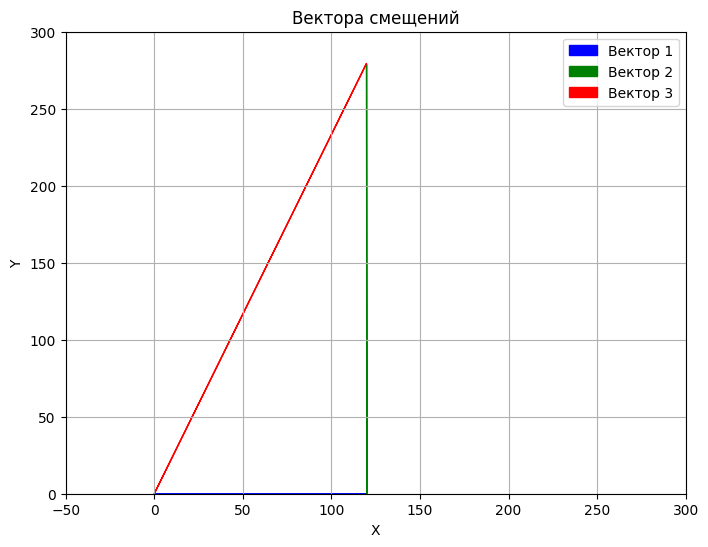

In [ ]:
#@title Построение векторов на основе перемещений всех остальных изображений
print(dx2, dy2)

print(dx3, dy3)

print(dx1, dy1)

plt.figure(figsize=(8, 6))  # Задаем размер графика

# Первый вектор
plt.arrow(0, 0, dx2, dy2, head_width=0.1, head_length=0.1, fc='blue', ec='blue', label='Вектор 1')

# Второй вектор (от конца первого)
plt.arrow(dx2, dy2, dx3, dy3, head_width=0.1, head_length=0.1, fc='green', ec='green', label='Вектор 2')

plt.arrow(0, 0, dx1, dy1, head_width=0.1, head_length=0.1, fc='red', ec='red', label='Вектор 3')

# Настройка графика
plt.xlim(-50, 300)  # Задаем пределы для оси X (подстройте под свои значения)
plt.ylim(0, 300)  # Задаем пределы для оси Y (подстройте под свои значения)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Вектора смещений")
plt.grid(True)
plt.legend()

plt.show()

Число найденных областей: 690
Число найденных областей: 681
Отфильтровано сопоставление 0 <-> 4 с похожестью 0.93 из-за порога 0.94
Отфильтровано сопоставление 1 <-> 1 с похожестью 0.90 из-за порога 0.94
Отфильтровано сопоставление 2 <-> 35 с похожестью 0.86 из-за порога 0.94
Отфильтровано сопоставление 8 <-> 24 с похожестью 0.81 из-за порога 0.94
Отфильтровано сопоставление 9 <-> 5 с похожестью 0.91 из-за порога 0.94
Отфильтровано сопоставление 10 <-> 7 с похожестью 0.89 из-за порога 0.94
Отфильтровано сопоставление 13 <-> 15 с похожестью 0.87 из-за порога 0.94
Отфильтровано сопоставление 24 <-> 28 с похожестью 0.93 из-за порога 0.94
Среднее абсолютное отклонение углов: 10.94


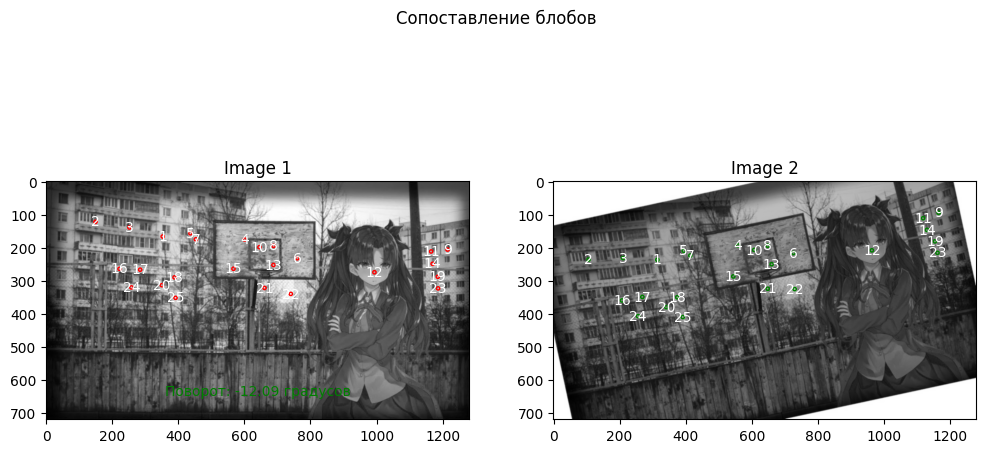

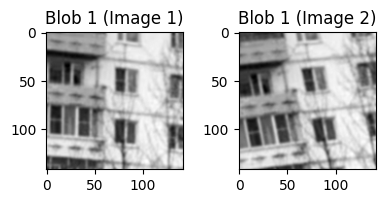

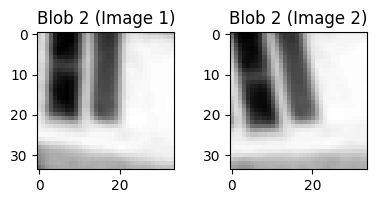

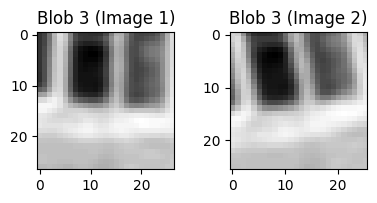

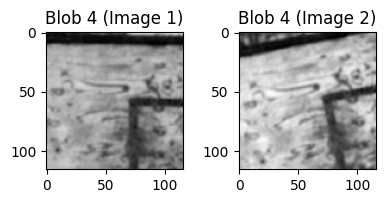

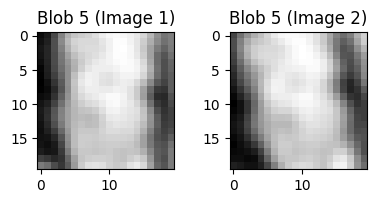

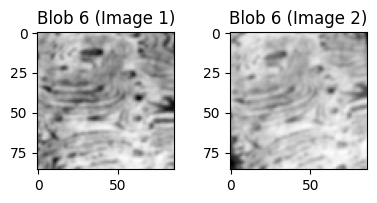

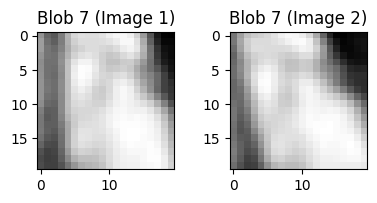

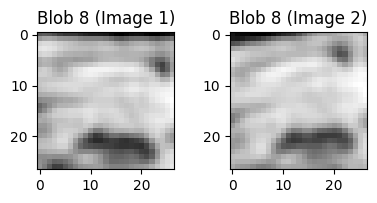

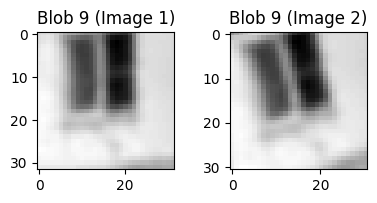

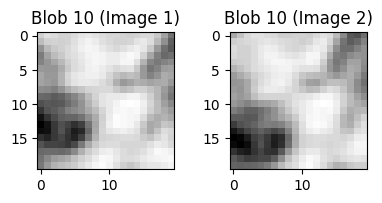

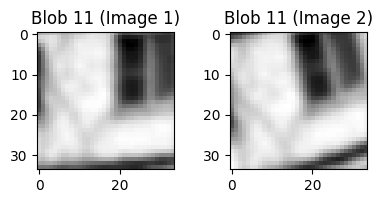

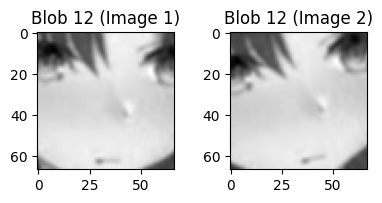

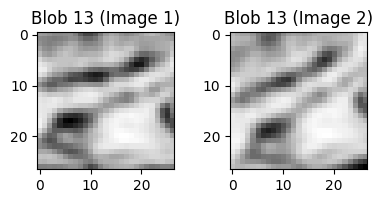

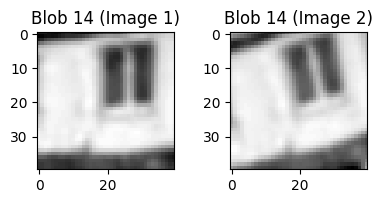

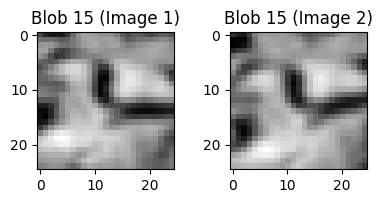

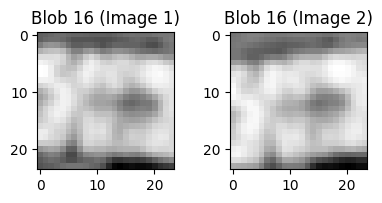

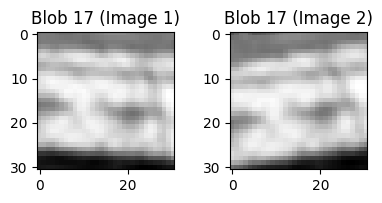

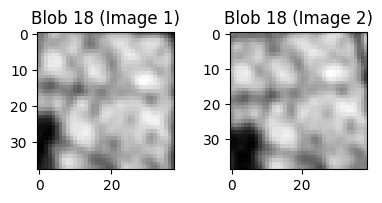

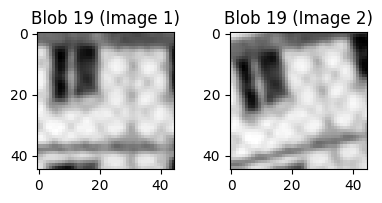

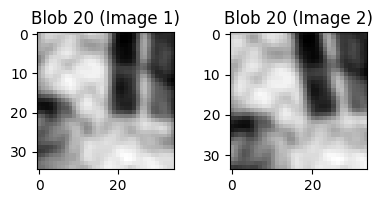

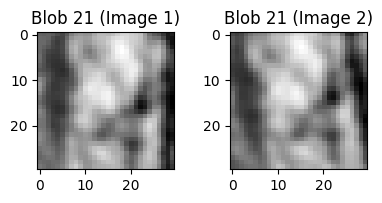

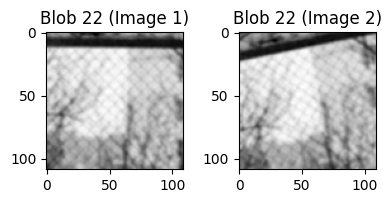

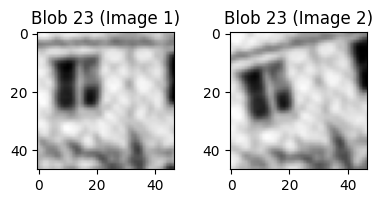

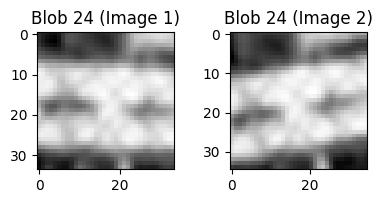

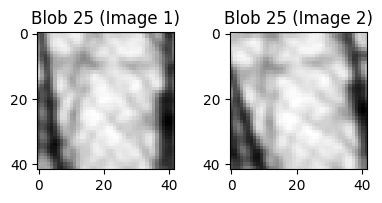

Обнаружен поворот. Оценка угла поворота: -12.09 градусов


In [ ]:
#@title Модель для вычисления поворота и перемещения изображения (одной пары)


image_one_rot

import numpy as np
from scipy.ndimage import label, gaussian_filter
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment  # Венгерский алгоритм
import cv2  # Импортируем OpenCV
import math
import random

def extract_blob_features(image, blob, blobs, k_neighbors=3):
    """Извлекает признаки из блоба, включая относительное расположение."""

    x, y, area = blob

    #Ограничиваем область, чтобы не вылезать за границы (предполагаем, что вся область стремится к форму круга)
    x_start = int(x - np.sqrt(area / np.pi))
    x_end = int(x + np.sqrt(area / np.pi))
    y_start = int(y - np.sqrt(area / np.pi))
    y_end = int(y + np.sqrt(area / np.pi))

    blob_image = image[max(0, y_start):min(image.shape[0], y_end), max(0, x_start):min(image.shape[1], x_end)] #Обрезаем изображение области на основе её центра и вычисленного радиуса

    # Вычисляем среднюю интенсивность
    mean_intensity = np.mean(blob_image)

    # Вычисляем LBP
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(blob_image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Нормализация

    # Находим k ближайших соседей
    distances = []
    neighbors = []

    for other_blob in blobs:
        if other_blob is not blob:
            x2, y2, _ = other_blob
            distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
            distances.append(distance)

    # Находим индексы k ближайших соседей
    neighbor_indices = np.argsort(distances)[:k_neighbors]  # Сортировка и берем только k

    # Преобразуем индексы соседей в блобы
    for idx in neighbor_indices:
        neighbors.append(blobs[idx])

    # Вычисляем относительные расстояния (нормализация по размеру изображения)
    relative_distances = []
    for neighbor in neighbors:
        x2, y2, _ = neighbor
        distance = np.sqrt((x - x2) ** 2 + (y - y2) ** 2)
        relative_distance = distance / max(image.shape[0], image.shape[1], 1)  # Нормализация
        relative_distances.append(relative_distance)

    # Заполняем нулями, если у блоба меньше k соседей
    while len(relative_distances) < k_neighbors:
        relative_distances.append(0.0)  # Добавляем нули

    # Вычисляем относительные углы
    relative_angles = []
    for neighbor in neighbors:
        x2, y2, _ = neighbor
        dx = x2 - x
        dy = y2 - y
        angle = math.atan2(dy, dx)  # Угол в радианах
        relative_angle = angle / (2 * np.pi)  # Нормализация
        relative_angles.append(relative_angle)

    while len(relative_angles) < k_neighbors:
        relative_angles.append(0.0)  # Добавляем нули

    return area, mean_intensity, hist, relative_distances, relative_angles


def compare_features(feature1, feature2, k_neighbors=3):
    """Сравнивает два набора признаков, учитывая относительное расположение."""
    area1, mean_intensity1, hist1, relative_distances1, relative_angles1 = feature1
    area2, mean_intensity2, hist2, relative_distances2, relative_angles2 = feature2

    # Вычисляем разницу признаков (нормализуем)
    area_diff = abs(area1 - area2) / max(area1, area2, 1)
    intensity_diff = abs(mean_intensity1 - mean_intensity2) / max(mean_intensity1, mean_intensity2, 1)
    hist_diff = np.sum(((hist1 - hist2) ** 2) / (hist1 + hist2 + 1e-7))  # avoid division by zero
    #  Вычисляем разницу по относительным расстояниям (L1-distance)
    relative_distance_diff = np.sum(np.abs(np.array(relative_distances1) - np.array(relative_distances2))) / k_neighbors  # L1, normalised by k
    relative_angle_diff = np.sum(np.abs(np.array(relative_angles1) - np.array(relative_angles2))) / k_neighbors

    #  Объединяем различия, увеличивая вес относительного расположения
    similarity = (
        0.40 * (1 - area_diff)
        + 0.30 * (1 - intensity_diff)
        + 0.10 * (1 - np.mean(hist_diff))
        + 0.10 * (1 - relative_distance_diff)  # Добавлено относительное расстояние
        + 0.10 * (1 - relative_angle_diff)  # Добавлено относительный угол
    )

    return similarity


def match_blobs(blobs1, blobs2, image1, image2, threshold=0.8):  # Изменили порог
    """Сопоставляет блобы между двумя изображениями, используя Венгерский алгоритм."""
    # Проверяем, что изображения не None
    if image1 is None or image2 is None:
        print("Ошибка: Одно или оба изображения не загружены.")
        return [], [], []  # Возвращаем пустые списки

    features1 = [extract_blob_features(image1, blob, blobs1) for blob in blobs1]
    features2 = [extract_blob_features(image2, blob, blobs2) for blob in blobs2]

    #Матрица сходств
    similarity_matrix = np.zeros((len(blobs1), len(blobs2)))
    for i, blob1 in enumerate(blobs1):
        for j, blob2 in enumerate(blobs2):
            similarity_matrix[i, j] = compare_features(features1[i], features2[j])

    # Инвертируем матрицу, чтобы использовать Венгерский алгоритм (поиск минимума)
    cost_matrix = 1 - similarity_matrix

    # Используем Венгерский алгоритм для нахождения оптимального сопоставления
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Отфильтровываем сопоставления по порогу сходства
    matches = []
    unmatched1 = list(range(len(blobs1)))
    unmatched2 = list(range(len(blobs2)))
    for i, j in zip(row_ind, col_ind):
        if similarity_matrix[i, j] > threshold:  # Изменили знак сравнения
            matches.append((i, j))  # (индекс блоба в blobs1, индекс блоба в blobs2)
            if i in unmatched1:
                unmatched1.remove(i)  # Удаляем из списка несопоставленных, так как сопоставление найдено
            if j in unmatched2:
                unmatched2.remove(j)  # Удаляем из списка несопоставленных
        else:
            print(
                f"Отфильтровано сопоставление {i} <-> {j} с похожестью {similarity_matrix[i, j]:.2f} из-за порога {threshold}"
            )  # Для отладки

    return matches, unmatched1, unmatched2  # Возвращаем индексы несопоставленных блобов


def estimate_shift(matches, blobs1, blobs2, inlier_threshold=2.0, max_iters=1000, confidence=0.99):
    """Оценивает смещение между двумя изображениями, используя RANSAC."""
    print("estimate_shift called")
    if not matches or len(matches) < 2:  # Нужно хотя бы 2 соответствия для RANSAC
        print("  Недостаточно сопоставлений для оценки смещения с использованием RANSAC.")
        return None

    # 1. Подготовка данных
    src_pts = np.float32([blobs1[i][:2] for i, _ in matches])  # Координаты блобов на первом изображении
    dst_pts = np.float32([blobs2[j][:2] for _, j in matches])  # Координаты блобов на втором изображении
    num_matches = len(matches)


    best_dx = 0
    best_dy = 0
    best_inliers = []

    # Вычисление минимального количества итераций
    e = 0.2  # Предполагаемая доля выбросов (можно настроить)
    s = 2  # Минимальное количество точек для модели (смещение требует 2 точки)
    N = int(np.log(1 - confidence) / np.log(1 - (1 - e)**s))
    max_iters = min(max_iters, N) # Адаптивное кол-во итераций

    for iter in range(max_iters):
        # (a) Выбираем случайную подвыборку из 's' точек
        sample_indices = np.random.choice(num_matches, 2, replace=False)
        i1, j1 = matches[sample_indices[0]]
        i2, j2 = matches[sample_indices[1]]

        # (b) Вычисляем предполагаемое смещение на основе этой подвыборки
        dx = (blobs1[i1][0] - blobs2[j1][0] + blobs1[i2][0] - blobs2[j2][0]) / 2
        dy = (blobs1[i1][1] - blobs2[j1][1] + blobs1[i2][1] - blobs2[j2][1]) / 2

        # (c) Находим внутренние точки (inliers) - точки, которые соответствуют модели
        inliers = []
        for k in range(num_matches):
            x1, y1 = src_pts[k]
            x2, y2 = dst_pts[k]
            error = np.sqrt((x1 - x2 - dx)**2 + (y1 - y2 - dy)**2) # Евклидово расстояние
            if error < inlier_threshold:
                inliers.append(k)

        # (d) Если нашли лучшую модель, запоминаем её
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_dx = dx
            best_dy = dy

    # 3. Уточнение оценки смещения (используя только внутренние точки)
    if len(best_inliers) > 0:
        inlier_src_pts = src_pts[best_inliers]
        inlier_dst_pts = dst_pts[best_inliers]
        best_dx = np.mean(inlier_src_pts[:, 0] - inlier_dst_pts[:, 0])
        best_dy = np.mean(inlier_src_pts[:, 1] - inlier_dst_pts[:, 1])
        print(f"  Смещение (RANSAC): dx={best_dx:.2f}, dy={-best_dy:.2f} (количество внутренних точек: {len(best_inliers)})")
        return best_dx, -best_dy  # Инвертируем dy
    else:
        print("  RANSAC не нашел надежного смещения.")
        return None


def estimate_rotation_matrix(matches, blobs1, blobs2):
    """Оценивает угол поворота с использованием матрицы аффинного преобразования."""
    if not matches or len(matches) < 3:
        return None

    # Подготовка данных для OpenCV
    src_pts = np.float32([blobs1[i][:2] for i, _ in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([blobs2[j][:2] for _, j in matches]).reshape(-1, 1, 2)

    # Вычисление матрицы аффинного преобразования
    try:
      retval, M = cv2.estimateAffine2D(src_pts, dst_pts)
    except Exception as e:
      print(f"Error in estimateAffine2D: {e}")
      return None

    if retval is None:
        return None

    # Извлечение матрицы поворота (первые два столбца, первые две строки)
    M = retval

    # Извлечение угла поворота из матрицы
    angle = math.atan2(M[1, 0], M[0, 0])

    return math.degrees(angle)


def calculate_angle(point1, point2):
    """Вычисляет угол между линией, соединяющей две точки, и горизонтальной осью."""
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    return math.atan2(dy, dx)


def analyze_transform(matches, blobs1, blobs2, num_pairs=10, angle_threshold=15):
    """Анализирует, произошло ли смещение или поворот, используя случайные пары точек."""
    if not matches or len(matches) < 3:
        return "Недостаточно соответствий"

    num_matches = len(matches)
    angle_differences = []

    #  Выбираем случайные пары.
    for _ in range(min(num_pairs, num_matches // 2)):  # Не берем больше пар, чем есть матчей
        #  Генерируем случайные индексы
        i1, j1 = random.choice(matches)  #  Случайный match
        i2, j2 = random.choice(matches)  #  Второй случайный match

        #  Получаем координаты
        x1_1, y1_1, _ = blobs1[i1]
        x1_2, y1_2, _ = blobs1[i2]
        x2_1, y2_1, _ = blobs2[j1]
        x2_2, y2_2, _ = blobs2[j2]

        #  Вычисляем углы
        angle1 = math.degrees(math.atan2(y1_2 - y1_1, x1_2 - x1_1))
        angle2 = math.degrees(math.atan2(y2_2 - y2_1, x2_2 - x2_1))

        #  Разница углов
        diff = abs(angle1 - angle2)

        #  Учитываем цикличность углов (от 0 до 360)
        diff = min(diff, 360 - diff)

        angle_differences.append(diff)

    #  Анализируем разности углов
    if angle_differences:
        avg_angle_diff = np.mean(angle_differences)
        print(f"Среднее абсолютное отклонение углов: {avg_angle_diff:.2f}")
        if avg_angle_diff > angle_threshold:
            return "Поворот" , avg_angle_diff # Поворот
        else:
            return "Смещение", avg_angle_diff  # Только смещение
    else:
        return "Невозможно определить", None  # Нет углов для вычисления


def process_images(image1_path, image2_path, threshold_blob, min_area, k_neighbors, lbp_radius=3, lbp_points=24, threshold = 0.8):
    """
    Обрабатывает два изображения, вычисляет смещения и угол поворота, используя LBP и относительные углы.
    """
    #Загруза изображений
    img_one = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img_two = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    #Гауссовый фильтр
    if img_one is not None:
        img_one = gaussian_filter(img_one, sigma=1)
    if img_two is not None:
        img_two = gaussian_filter(img_two, sigma=1)

    #Поиск блобов
    blobs1 = detect_blobs(img_one, threshold_blob, min_area)
    blobs2 = detect_blobs(img_two, threshold_blob, min_area)

    #Извлечение признаков блобов
    features1 = [extract_blob_features(img_one, blob, blobs1, k_neighbors) for blob in blobs1]
    features2 = [extract_blob_features(img_two, blob, blobs2, k_neighbors) for blob in blobs2]

    #Сопоставление блобов
    matches, unmatched1, unmatched2 = match_blobs(blobs1, blobs2, img_one, img_two, threshold=threshold)

    # 5. Анализ типа преобразования
    transform_type, angle_diff = analyze_transform(matches, blobs1, blobs2, num_pairs = 10, angle_threshold=5) # Адаптивный порог

    # 6. Оценка параметров преобразования.
    shift = None
    rotation = None

    #Стандартные значения
    result_string = ""
    rotation_string = ""
    shift_string = ""

    if transform_type == "Поворот":
        rotation = estimate_rotation_matrix(matches, blobs1, blobs2)
        if rotation is not None:
            rotation_string = f"Обнаружен поворот. Оценка угла поворота: {rotation:.2f} градусов"
        else:
            rotation_string = "Обнаружен поворот, но не удалось оценить угол поворота."
    elif transform_type == "Смещение":
        shift = estimate_shift(matches, blobs1, blobs2) # inlier threshold is now parameter
        if shift is not None:
            shift_string = f"Обнаружено только смещение. Оценка смещения: dx={shift[0]:.2f}, dy={shift[1]:.2f}"
        else:
            shift_string = "Обнаружено только смещение, но не удалось оценить смещение."
    else:
        result_string = transform_type # Недостаточно соответствий, невозможно определить.

    # 7. Составление результата
    if rotation_string and shift_string:
        result_string = rotation_string + "\n" + shift_string # Поворот + Смещение
    elif rotation_string:
        result_string = rotation_string # Только поворот
    elif shift_string:
        result_string = shift_string # Только смещение
    else:
        result_string = transform_type # Недостаточно соответствий, невозможно определить.

    # 8. Визуализация (здесь нужна будет доработка)
    visualize_matches(img_one, blobs1, img_two, blobs2, matches, title="Сопоставление блобов", shift=shift, rotation=rotation)

    return result_string, shift, rotation

def visualize_matches(
    image1, blobs1, image2, blobs2, matches, title="Сопоставление блобов", shift=None, rotation=None
):
    """Отображает изображения с сопоставленными блобами."""
    num_matches = len(matches)

    # Main Images with annotations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image1, cmap='gray')
    ax1.set_title("Image 1")
    ax2.imshow(image2, cmap='gray')
    ax2.set_title("Image 2")

    # Create sorted list for correct numeration on the image
    new_matches = [] # List for draw_matches
    # Annotate blob matches. We iterate with *new* indexes.
    for k, (i, j) in enumerate(matches):
        x1, y1, _ = blobs1[i]
        x2, y2, _ = blobs2[j]
        circle1 = plt.Circle((x1, y1), radius=5, color='r', fill=False) # TODO radius should be parametrized
        ax1.add_patch(circle1)
        ax1.text(x1, y1, str(k + 1), color='white', ha='center', va='center') # number k+1

        circle2 = plt.Circle((x2, y2), radius=5, color='g', fill=False)  # TODO radius should be parametrized
        ax2.add_patch(circle2)
        ax2.text(x2, y2, str(k + 1), color='white', ha='center', va='center')  # number k+1

        new_matches.append((i, j))

    # Добавляем стрелку, показывающую смещение, если есть
    if shift:
        dx, dy = shift
        center_x = image1.shape[1] / 2  # Середина по горизонтали
        center_y = image1.shape[0] / 2  # Середина по вертикали
        ax1.arrow(center_x, center_y, dx, -dy, head_width=10, head_length=10, fc='blue', ec='blue')  # Инвертируем dy
        ax1.text(center_x + dx * 1.2, center_y - dy * 1.2, f"Смещение: dx={dx:.2f}, dy={dy:.2f}", color='blue')  # Инвертируем dy

    # Добавляем информацию о повороте, если есть
    if rotation:
        angle = rotation
        ax1.text(0.5, 0.1, f"Поворот: {angle:.2f} градусов", color='green', transform=ax1.transAxes, ha='center')

    plt.suptitle(title)
    plt.show()


    #  Display Cropped Images on a Separate Figure
    for k, (i, j) in enumerate(matches):
      #New images with cropped images
        fig, axes = plt.subplots(1, 2, figsize=(4, 2))

        # Extract image parts, etc.
        x1, y1, area1 = blobs1[i]
        x2, y2, area2 = blobs2[j]

        size1 = int(2 * np.sqrt(area1 / np.pi)) #Circle diameter
        size2 = int(2 * np.sqrt(area2 / np.pi))

        crop1 = crop_blob(image1, x1, y1, size1)
        crop2 = crop_blob(image2, x2, y2, size2)

        # Display cropped
        axes[0].imshow(crop1, cmap='gray')
        axes[0].set_title(f"Blob {k + 1} (Image 1)")  # index now k+1
        axes[1].imshow(crop2, cmap='gray')
        axes[1].set_title(f"Blob {k + 1} (Image 2)")  # index now k+1

        plt.tight_layout()  # Automate place for plots
        plt.show()  # Create a *separate* picture with each cut



def crop_blob(image, x, y, size):
    """Вырезает квадратный фрагмент изображения вокруг блоба."""
    x_start = int(x - size / 2)
    x_end = int(x + size / 2)
    y_start = int(y - size / 2)
    y_end = int(y + size / 2)

    # Обрезаем и обрабатываем граничные случаи
    x_start = max(0, x_start)
    y_start = max(y_start, 0)  # Исправлено
    x_end = min(x_end, image.shape[1])  # Исправлено
    y_end = min(y_end, image.shape[0])  # Исправлено

    return image[y_start:y_end, x_start:x_end]


def detect_blobs(image, threshold, min_area):

    #Бинаризация изображения
    binary_image = image > threshold

    #Связный анализ компонентов (разбиение на области)
    labeled_image = label(binary_image)
    num_labels = labeled_image[1]
    print("Число найденных областей: " + str(num_labels))

    #Извлечение свойств блобов
    blobs = []
    for i in range(1, num_labels + 1):  #Индексация областей идёт с 1 (0 - фон, который не может являться областью для поиска особой точки)
        blob_pixels = np.where(labeled_image[0] == i)
        y_coords = blob_pixels[0]
        x_coords = blob_pixels[1]

        area = len(y_coords)

        # Фильтрация по площади
        if area >= min_area:
            # Вычисление центра масс (центроида)
            center_x = np.mean(x_coords)
            center_y = np.mean(y_coords)

            blobs.append((center_x, center_y, area))

    return blobs

#Указание путей изображения
image1_path = '/content/CV_LB2/one.jpg'
#image2_path = image_generate
#image2_path = image_one_UP_y

image2_path = image_one_rot


#Параметры
threshold = 128 # Порог бинаризации
min_area = 310  # Минимальное число пикселей в области, которая будет обрабатываться
k_neighbors = 3  # Количество ближайших соседей для учета расположения блобов
lbp_radius = 3
lbp_points = 24
threshold_match = 0.94 #Требуемая точность (применяется в определении блобов)

# Вызываем process_images
result, shift, rotation = process_images(image1_path, image2_path, threshold, min_area, k_neighbors, lbp_radius, lbp_points, threshold_match)

# Вывод результатов
print(result)

In [ ]:
#@title Модель для вычисления поворота (в том числе фрагмента изображения) и перемещения изображения (одной пары)

Тут сделать пикчу с поворотом девочки и после проанализировать может ли система распозонать её поворот, а не поворт всей картинки
